## General

### Installs

In [ ]:
%pip install keras
%pip install tensorflow
%pip install matplotlib
%pip install scikit-learn
%pip install pillow
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Imports


In [1]:
import os
import keras
import random
import shutil
import numpy as np
import seaborn as sns
import tensorflow as tf

from os import path
from keras import layers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, RandomBrightness, RandomRotation, RandomZoom, RandomContrast, Conv2D, MaxPooling2D, Flatten, Dropout, Normalization, Conv2DTranspose
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors


## Question 1 A

In [2]:
# TODO: delete
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Load the data

In [3]:
all_labels = ['NORMAL', 'PNEUMONIA']
# TODO: change it
base_dir = "/Users/neriya.shulman/content/chest_xray"
img_size = 250


In [4]:

def load_data(base_dir, img_size, all_labels):
    dataset = []
    labels = []
    file_names = []
    for dir_ in os.scandir(base_dir):
        if not dir_.is_dir():
            continue
        label = all_labels.index(dir_.name)
        for file in os.scandir(dir_.path):
            if file.name == '.DS_Store':
                continue
            img = load_img(file.path, target_size=(img_size, img_size), color_mode='grayscale')
            arr_img = img_to_array(img)
            dataset.append(arr_img)
            labels.append(label) # change label to 0 or 1
            file_names.append(file.name)
    dataset = np.array(dataset, dtype='float32')
    labels = np.expand_dims(labels, -1)
    file_names = np.expand_dims(file_names, -1)
    return dataset, labels, file_names

In [5]:
orig_train_set, orig_train_labels, train_file_names = load_data(path.join(base_dir, "train"), img_size, all_labels)
orig_validation_set, orig_validation_labels, _ = load_data(path.join(base_dir, "val"), img_size, all_labels)
test_set, test_labels, _ = load_data(path.join(base_dir, "test"), img_size, all_labels)

### Data preprocessing

Normalization

In [6]:
orig_train_set /= 255
orig_validation_set /= 255
test_set /= 255

Increase validation set

In [7]:
print('validation set size before moving from the train: ', len(orig_validation_set))

num_to_move = 200
normal_indexes = [i for i, label in enumerate(orig_train_labels.reshape(-1)) if label == 0]
bacteria_indexes = [i for i, file in enumerate(train_file_names.reshape(-1)) if 'bacteria' in file]
virus_indexes = [i for i, file in enumerate(train_file_names.reshape(-1)) if 'virus' in file]

new_indexes = np.concatenate((normal_indexes[:num_to_move], bacteria_indexes[:num_to_move//2], virus_indexes[:num_to_move//2]), axis=0)
validation_set = np.concatenate((orig_validation_set, orig_train_set[new_indexes]), axis=0)
validation_labels = np.concatenate((orig_validation_labels, orig_train_labels[new_indexes]), axis=0)

train_set = np.delete(orig_train_set, new_indexes, axis=0)
train_labels = np.delete(orig_train_labels, new_indexes, axis=0)

print('validation set size after moving: ', len(validation_set))


validation set size before moving from the train:  16
validation set size after moving:  416


Balance the training data

Number of images in training set:  4816
Number of Normal images:  1141
Number of Pneumonia images:  3675
Ratio between classes: 24:76


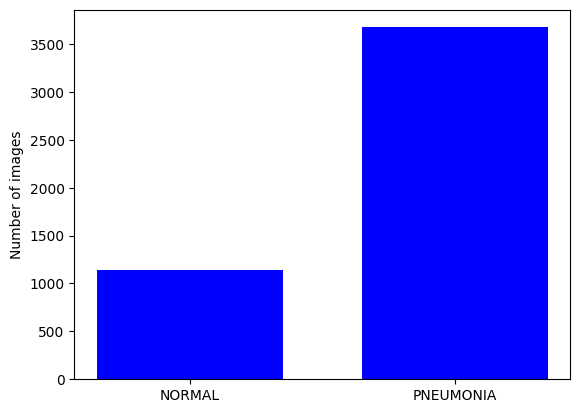

In [8]:
normal_train_data = train_set[train_labels[:, 0] == 0] 
pneum_train_data = train_set[train_labels[:, 0] == 1]

print('Number of images in training set: ', len(train_set))
print('Number of Normal images: ', len(normal_train_data))
print('Number of Pneumonia images: ', len(pneum_train_data))

ratio_normal = round(len(normal_train_data)/len(train_set)*100)
ratio_pneum = round(len(pneum_train_data)/len(train_set)*100)
print(f'Ratio between classes: {ratio_normal}:{ratio_pneum}')

plt.hist(train_labels, bins=2, color='blue', rwidth=0.7)
plt.ylabel('Number of images')
plt.xticks([0.25, 0.75], ['NORMAL', 'PNEUMONIA'])
plt.show()

Balance the data by multiplying the normal images

In [9]:
multiply_by = round(len(pneum_train_data) / len(normal_train_data))
normal_train_data = np.concatenate([normal_train_data for _ in range(multiply_by)], axis=0)
normal_train_labels = np.full((len(normal_train_data), 1), all_labels.index('NORMAL'))
pneum_train_labels = np.full((len(pneum_train_data), 1), all_labels.index('PNEUMONIA'))

train_set = np.concatenate([normal_train_data, pneum_train_data], axis=0)
train_labels = np.concatenate([normal_train_labels, pneum_train_labels], axis=0)

Number of Normal images:  3423
Number of Pneumonia images:  3675
Ratio between classes: 48:52


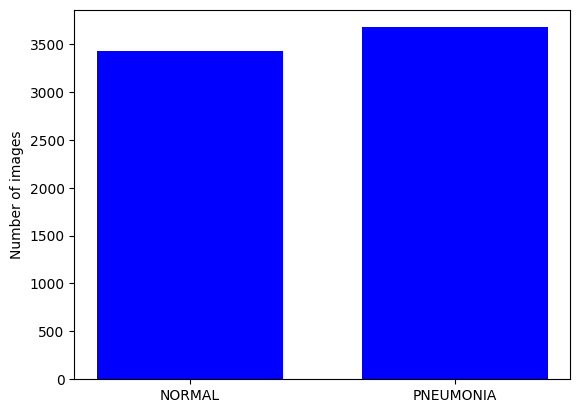

In [10]:
print('Number of Normal images: ', len(normal_train_data))
print('Number of Pneumonia images: ', len(pneum_train_data))
print(f'Ratio between classes: {round(len(normal_train_data)/len(train_set)*100)}:{round(len(pneum_train_data)/len(train_set)*100)}')
plt.hist(train_labels.squeeze(), bins=2, color='blue', rwidth=0.7)
plt.ylabel('Number of images')
plt.xticks([0.25, 0.75], ['NORMAL', 'PNEUMONIA'])
plt.show()

Shuffling

In [11]:
def shuffle_dataset(dataset, labels):
    indices = np.arange(dataset.shape[0])
    np.random.shuffle(indices)
    return dataset[indices], labels[indices]

train_set, train_labels = shuffle_dataset(train_set, train_labels)

### The model

In [12]:
max_epochs = 50
batch_size = 64
learning_rate=0.001

In [13]:


model = Sequential(
    [
        keras.Input(shape=(img_size, img_size, 1)),
        RandomRotation(0.35),
        RandomZoom(0.1),
        RandomBrightness(0.15, value_range=(0,1)),
        RandomContrast(0.1),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(name='flatten'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dropout(0.5),
        Dense(units=32, activation='relu'),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid'),
    ]
)

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy", "recall", "precision"])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(train_set, train_labels, epochs=max_epochs, batch_size=batch_size,
        validation_data=(validation_set, validation_labels), callbacks=[early_stopping])


2024-04-15 20:44:01.096591: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-15 20:44:01.096612: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-15 20:44:01.096618: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-15 20:44:01.096810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 20:44:01.096826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-04-15 20:44:02.199138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.5691 - loss: 0.7860 - precision: 0.6098 - recall: 0.4509 - val_accuracy: 0.7019 - val_loss: 0.5974 - val_precision: 0.6288 - val_recall: 0.9856
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7945 - loss: 0.4801 - precision: 0.8030 - recall: 0.8070 - val_accuracy: 0.9207 - val_loss: 0.2072 - val_precision: 0.9534 - val_recall: 0.8846
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8764 - loss: 0.3368 - precision: 0.8934 - recall: 0.8640 - val_accuracy: 0.8750 - val_loss: 0.2880 - val_precision: 0.9875 - val_recall: 0.7596
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8914 - loss: 0.3032 - precision: 0.9141 - recall: 0.8720 - val_accuracy: 0.9375 - val_loss: 0.1767 - val_precision: 0.9691 - val_recall: 0.9038
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8917 - loss: 0.3078 - precision: 0.9107 - recall: 0.8765 - val_accuracy: 0.8990 - val_loss: 0.2

save the model

In [14]:
model.save('model_q1_a.keras')

## Question 1 B

### Loading the data

In [ ]:
all_labels = ['NORMAL', 'virus', 'bacteria']
base_dir = "/Users/neriya.shulman/content/chest_xray"

train_path = path.join(base_dir, "train/")
val_path = path.join(base_dir, "val/")
test_path = path.join(base_dir, "test/")

img_size = 250
print("Image size: ", img_size, "x", img_size)

Image size:  250 x 250


In [ ]:
def get_label(dir_name, file_name, file_labels=[]):
    for label in file_labels:
        if label in file_name:
            return label
    return dir_name

def load_data_from_path(base_dir, img_size, file_labels=[]):
    dataset = []
    labels = []
    dir_names = os.path.basename(base_dir)
    for file in os.scandir(base_dir):
        if file.name == '.DS_Store':
            continue
        if file.is_dir():
            dir_images, dir_labels = load_data_from_path(file.path, img_size, file_labels)
            dataset.extend(dir_images)
            labels.extend(dir_labels)
        else:
            img = img_to_array(load_img(file.path, target_size=(img_size, img_size), color_mode='grayscale'))
            dataset.append(img)
            labels.append(get_label(dir_names, file.name, file_labels))
    dataset = np.array(dataset, dtype='float32')
    labels = np.array(labels)
    return dataset, labels

def load_data(path, img_size, all_labels, file_labels=[]):
    dataset, labels = load_data_from_path(path, img_size, file_labels)
    labels = np.array([all_labels.index(label) for label in labels]) # one-hot encoding
    labels = to_categorical(labels, len(all_labels))
    return dataset, labels

In [ ]:
orig_train_set, orig_train_labels = load_data(train_path, img_size, all_labels, file_labels=['bacteria', 'virus'])
orig_validation_set, orig_validation_labels = load_data(val_path, img_size, all_labels, file_labels=['bacteria', 'virus'])
test_set, test_labels = load_data(test_path, img_size, all_labels, file_labels=['bacteria', 'virus'])

print('Number of classes: ', len(all_labels))
print('Number of total samples: ', len(orig_train_set))

Number of classes:  3
Number of total samples:  5216


### Data preprocessing

Normalization

In [ ]:
orig_train_set /= 255
orig_validation_set /= 255
test_set /= 255

Increase validation set

In [ ]:
print('validation set size before moving from the train: ', len(orig_validation_set))

num_to_move = 200
normal_indexes = np.where(np.all(orig_train_labels == to_categorical(0, len(all_labels)), axis=1))[0]
bacteria_indexes = np.where(orig_train_labels[np.all(orig_train_labels == to_categorical(1, len(all_labels)), axis=1)])[0]
virus_indexes = np.where(orig_train_labels[np.all(orig_train_labels == to_categorical(2, len(all_labels)), axis=1)])[0]

new_indexes = np.concatenate((normal_indexes[:num_to_move], bacteria_indexes[:num_to_move//2], virus_indexes[:num_to_move//2]), axis=0)
validation_set = np.concatenate((orig_validation_set, orig_train_set[new_indexes]), axis=0)
validation_labels = np.concatenate((orig_validation_labels, orig_train_labels[new_indexes]), axis=0)

train_set = np.delete(orig_train_set, new_indexes, axis=0)
train_labels = np.delete(orig_train_labels, new_indexes, axis=0)

print('validation set size after moving: ', len(validation_set))

validation set size before moving from the train:  16
validation set size after moving:  416


Balance the training data

In [ ]:
normal_label = to_categorical(all_labels.index('NORMAL'), len(all_labels))
virus_label = to_categorical(all_labels.index('virus'), len(all_labels))
bacteria_label = to_categorical(all_labels.index('bacteria'), len(all_labels))

normal_train_data = train_set[np.all(train_labels == normal_label, axis=1)] 
bacteria_train_data = train_set[np.all(train_labels == bacteria_label, axis=1)]
virus_train_data = train_set[np.all(train_labels == virus_label, axis=1)]

Number of images in training set:  4916
Ratio between classes: 23:50:27


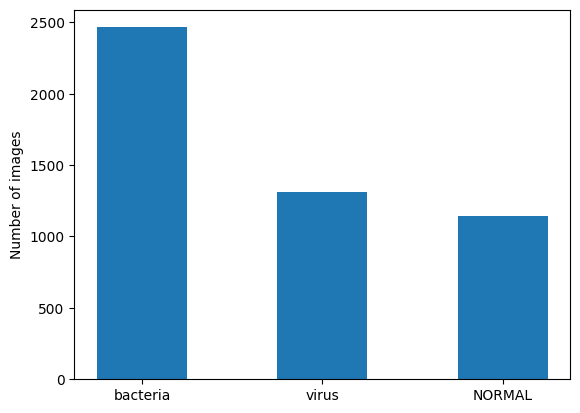

In [ ]:
print('Number of images in training set: ', len(train_set))
ratio_normal = round(len(normal_train_data)/len(train_set)*100)
ratio_bacteria = round(len(bacteria_train_data)/len(train_set)*100)
ratio_virus = round(len(virus_train_data)/len(train_set)*100)
print(f'Ratio between classes: {ratio_normal}:{ratio_bacteria}:{ratio_virus}')

label_names = {(1., 0., 0.): 'NORMAL', (0., 1., 0.): 'virus', (0., 0., 1.): 'bacteria'}
arr = np.array([label_names[tuple(x)] for x in train_labels])
plt.hist(arr, bins=3, rwidth=0.5)
plt.ylabel('Number of images')
nc = len(set(arr)) 
plt.xticks(np.linspace(0, nc-1, 2*nc+1)[1::2])
plt.show()

Balance the data by multiplying the normal and the bacteria images

In [ ]:
multiply_train_by = round(max(len(bacteria_train_data), len(virus_train_data)) / len(normal_train_data))
normal_train_data = np.concatenate([normal_train_data for _ in range(multiply_train_by)], axis=0)
normal_train_labels = np.full((len(normal_train_data), 3), normal_label)

multiply_virus_by = round(max(len(normal_train_data), len(bacteria_train_data)) / len(virus_train_data))
virus_train_data = np.concatenate([virus_train_data for _ in range(multiply_virus_by)], axis=0)
virus_train_labels = np.full((len(virus_train_data), 3), virus_label)
bacteria_train_labels = np.full((len(bacteria_train_data), 3), bacteria_label)

train_set = np.concatenate([normal_train_data, virus_train_data, bacteria_train_data], axis=0)
train_labels = np.concatenate([normal_train_labels, virus_train_labels, bacteria_train_labels], axis=0)


Number of images in training set:  7367
Ratio between classes: 31:33:36


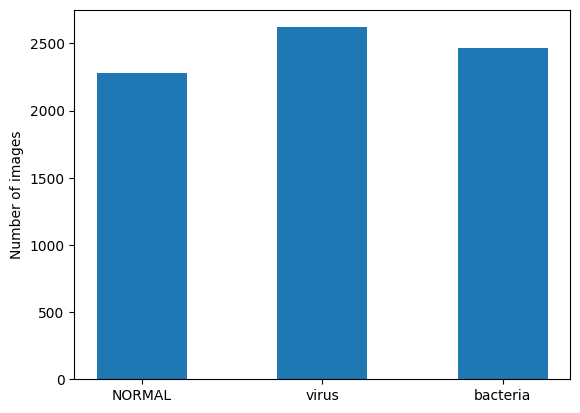

In [ ]:
print('Number of images in training set: ', len(train_set))
ratio_normal = round(len(normal_train_data)/len(train_set)*100)
ratio_bacteria = round(len(bacteria_train_data)/len(train_set)*100)
ratio_virus = round(len(virus_train_data)/len(train_set)*100)
print(f'Ratio between classes: {ratio_normal}:{ratio_bacteria}:{ratio_virus}')

label_names = {(1., 0., 0.): 'NORMAL', (0., 1., 0.): 'virus', (0., 0., 1.): 'bacteria'}
arr = np.array([label_names[tuple(x)] for x in train_labels])
plt.hist(arr, bins=3, rwidth=0.5)
plt.ylabel('Number of images')
nc = len(set(arr)) 
plt.xticks(np.linspace(0, nc-1, 2*nc+1)[1::2])
plt.show()

Shuffling

In [ ]:
def shuffle_dataset(dataset, labels):
    indices = np.arange(dataset.shape[0])
    np.random.shuffle(indices)
    return dataset[indices], labels[indices]

train_set, train_labels = shuffle_dataset(train_set, train_labels)

### The model

In [ ]:
max_epochs = 50
batch_size = 64
learning_rate=0.001
print("Batch size: ", batch_size)

Batch size:  64


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(img_size, img_size, 1)),
        RandomRotation(0.35),
        RandomZoom(0.1),
        RandomBrightness(0.02, value_range=(0,1)),
        RandomContrast(0.02),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(name='flatten'),
        Dense(units=1024, activation='relu'),
        Dense(units=526, activation='relu'),
        Dropout(0.25),
        Dense(units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(len(all_labels), activation='softmax'),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "recall", "precision"])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(train_set, train_labels, epochs=max_epochs, batch_size=batch_size,
        validation_data=(validation_set, validation_labels), callbacks=[early_stopping])


2024-04-15 18:18:44.476697: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-15 18:18:44.476721: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-15 18:18:44.476727: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-15 18:18:44.476746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 18:18:44.476756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-04-15 18:18:45.721354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 325ms/step - accuracy: 0.3726 - loss: 1.0938 - precision: 0.4403 - recall: 0.0410 - val_accuracy: 0.6562 - val_loss: 0.9595 - val_precision: 0.7000 - val_recall: 0.2188
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 309ms/step - accuracy: 0.5274 - loss: 0.9744 - precision: 0.5877 - recall: 0.2864 - val_accuracy: 0.6659 - val_loss: 0.7598 - val_precision: 0.7786 - val_recall: 0.5240
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - accuracy: 0.6208 - loss: 0.8547 - precision: 0.6685 - recall: 0.4817 - val_accuracy: 0.7596 - val_loss: 0.6918 - val_precision: 0.7977 - val_recall: 0.6731
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 469ms/step - accuracy: 0.6451 - loss: 0.8208 - precision: 0.6946 - recall: 0.5362 - val_accuracy: 0.7957 - val_loss: 0.5660 - val_precision: 0.8189 - val_recall: 0.7716
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 469ms/step - accuracy: 0.6537 - loss: 0.8000 - precision: 0.6989 - recall: 0.5510 - val_accuracy: 0.7428 - val_loss

save the model

In [ ]:
model.save('model_q1_b.keras')

## Question 3

### Load data

In [24]:
# TODO: delete it
np.random.seed(100)
random.seed(100)
tf.random.set_seed(100)

image_size = 250
# TODO: change it
base_dir = "/Users/neriya.shulman/content/chest_xray"

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [25]:
def load_images(dir_path, image_size):
    images = []
    files = os.listdir(dir_path)
    for filename in files:
        if filename == '.DS_Store':
            continue
        img_path = os.path.join(dir_path, filename)
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=(image_size, image_size), color_mode='grayscale')
            images.append(img)
    images = np.array(images, dtype='float32')
    images = np.expand_dims(images, -1) # image should be (height, width, channels)
    return images

In [26]:

train_set = load_images(os.path.join(train_dir, 'NORMAL'), image_size)
validation_set = load_images(os.path.join(val_dir, 'NORMAL'), image_size)

normal_test_set = load_images(os.path.join(test_dir, 'NORMAL'), image_size)
normal_test_labels = np.full(len(normal_test_set), 'NORMAL')
anomal_test_set = load_images(os.path.join(test_dir, 'PNEUMONIA'), image_size)
anomal_test_labels = np.full(len(anomal_test_set), 'PNEUMONIA')
test_set = np.concatenate((normal_test_set, anomal_test_set), axis=0)
test_labels = np.concatenate((normal_test_labels, anomal_test_labels), axis=0)

input_shape = (image_size, image_size, 1)
print('shape:', input_shape)

shape: (250, 250, 1)


### Data preprocessing

Normalization

In [27]:
train_set /= 255
validation_set /= 255
test_set /= 255

Data augmentation

In [28]:
def augment_data(data_set, multiply=1):
    augmented_data = [data_set]
    for _ in range(multiply):
        data = RandomRotation(0.35)(data_set)
        data = RandomZoom(0.1)(data_set)
        data = RandomBrightness(0.15, value_range=(0,1))(data_set)
        data = RandomContrast(0.1)(data_set)
        augmented_data.append(data)
    return np.concatenate(augmented_data)

train_set = augment_data(train_set, 2)

### The model

In [29]:

normalization_layer = Normalization()
normalization_layer.adapt(train_set)

model = Sequential([
    normalization_layer,
    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    Conv2D(32, (3, 3), activation="relu"),
    Conv2DTranspose(64, (3, 3), activation="relu"),
    Conv2DTranspose(128, (3, 3), activation="relu"),
    Conv2DTranspose(1, (3, 3), activation="sigmoid")
])


loss = "mean_squared_error"
print('loss:', loss)

model.compile(optimizer="adam", loss=loss, metrics=["mean_squared_error"])

batch_size = 32
print('batch_size:', batch_size)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(train_set, train_set,
                epochs=30,
                batch_size=batch_size,
                callbacks=[early_stopping],
                validation_data=(validation_set, validation_set))

loss: mean_squared_error
batch_size: 32
Epoch 1/30


2024-04-15 19:55:29.608268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


126/126 ━━━━━━━━━━━━━━━━━━━━ 49s 370ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 5.4739e-04 - val_mean_squared_error: 5.4739e-04
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 401ms/step - loss: 4.2828e-04 - mean_squared_error: 4.2828e-04 - val_loss: 2.7804e-04 - val_mean_squared_error: 2.7804e-04
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 532ms/step - loss: 1.6403e-04 - mean_squared_error: 1.6403e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - loss: 4.9898e-04 - mean_squared_error: 4.9898e-04 - val_loss: 1.9679e-04 - val_mean_squared_error: 1.9679e-04
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - loss: 7.7016e-05 - mean_squared_error: 7.7016e-05 - val_loss: 1.7615e-04 - val_mean_squared_error: 1.7615e-04
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - loss: 6.0785e-05 - mean_squared_error: 6.0785e-05 - val_loss: 1.6807e-04 - val_mean_squared_error: 1.6807e-04
Epoch 7/30
126/126 ━━━━━━

save the model

In [30]:
model.save('model_q3.keras')